In [1]:
import sys

DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)

In [2]:
from comet_ml import Experiment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import os
import xgboost as xgb

from visualizations.simple_visualization import *
from models.generate_plots import *
from features.feature_eng1 import *

In [3]:
data = pd.read_csv(DATA_PATH + '/clean_train_data.csv', index_col=0)
data

,gameSeconds,period,x_coordinate,y_coordinate,shotDistance,shotAngle,shotType,LastEventType,Last_x_coordinate,Last_y_coordinate,timeFromLastEvent,DistanceLastEvent,Rebound,changeShotAngle,speed,time_since_pp,no_players_home,no_players_away,is_goal
0,15,1,36.0,-23.0,57.775427,23.459024,Wrist Shot,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,0.0,5.0,5.0,0
1,20,1,63.0,0.0,26.000000,0.000000,Wrist Shot,Shot,36.0,-23.0,5.0,35.468296,True,23.459024,7.093659,0.0,5.0,5.0,1
2,121,1,79.0,0.0,10.000000,0.000000,Tip-In,Goal,63.0,0.0,101.0,16.000000,False,0.000000,0.158416,0.0,5.0,5.0,0
3,154,1,-69.0,-16.0,25.612497,38.659808,Wrist Shot,Shot,79.0,0.0,33.0,148.862353,True,38.659808,4.510980,0.0,5.0,5.0,0
4,165,1,-63.0,-12.0,28.635642,24.775141,Wrist Shot,Shot,-69.0,-16.0,11.0,7.211103,True,63.434949,0.655555,0.0,5.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2360,4,-34.0,-24.0,60.008333,23.574706,Wrist Shot,Shot,30.0,-29.0,832.0,64.195015,True,49.749996,0.077157,0.0,5.0,5.0,0
327338,2404,4,-69.0,32.0,37.735925,57.994617,Slap Shot,Shot,-34.0,-24.0,44.0,66.037868,True,81.569323,1.500861,0.0,5.0,5.0,0
327339,2440,4,82.0,26.0,26.925824,74.931512,Slap Shot,Shot,-69.0,32.0,36.0,151.119158,True,132.926129,4.197754,0.0,5.0,5.0,0
327340,2728,4,-62.0,-29.0,39.623226,47.045408,Snap Shot,Shot,82.0,26.0,288.0,154.146035,True,121.976920,0.535229,0.0,5.0,5.0,0


In [4]:
X = data[['shotDistance', 'shotAngle', 'is_goal' ]]
X

,shotDistance,shotAngle,is_goal
0,57.775427,23.459024,0
1,26.000000,0.000000,1
2,10.000000,0.000000,0
3,25.612497,38.659808,0
4,28.635642,24.775141,0
...,...,...,...
327337,60.008333,23.574706,0
327338,37.735925,57.994617,0
327339,26.925824,74.931512,0
327340,39.623226,47.045408,0


In [5]:
has_nan = X.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    
    # Dropping NaNs since these events do not have x and y coordinates
    X.dropna(inplace=True)
    X = X.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")
X.shape

There are NaN values in the DataFrame 'X'.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(318180, 3)

In [6]:
X, y = X.iloc[:, :-1], X.iloc[:, -1]
y

0         0
1         1
2         0
3         0
4         0
         ..
318175    0
318176    0
318177    0
318178    0
318179    1
Name: is_goal, Length: 318180, dtype: int64

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
# Compute metrics
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
metrics = {"accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision}
params = {
    "model": 'XGBoost',
    "description": 'XGBClassifier Baseline Distance+Angle',
}
metrics

{'accuracy': 0.905368030674461,
 'f1': 0.006816932380428807,
 'recall': 0.003434903047091413,
 'precision': 0.44285714285714284}

In [ ]:
experiment = Experiment(
  api_key='lqXuPyhuPClaazZKtvHZe5jFS',
  project_name="nhl-project-b10",
  workspace="ift6758b-project-b10"
)

In [ ]:
experiment.set_name('XGBoost Baseline')
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

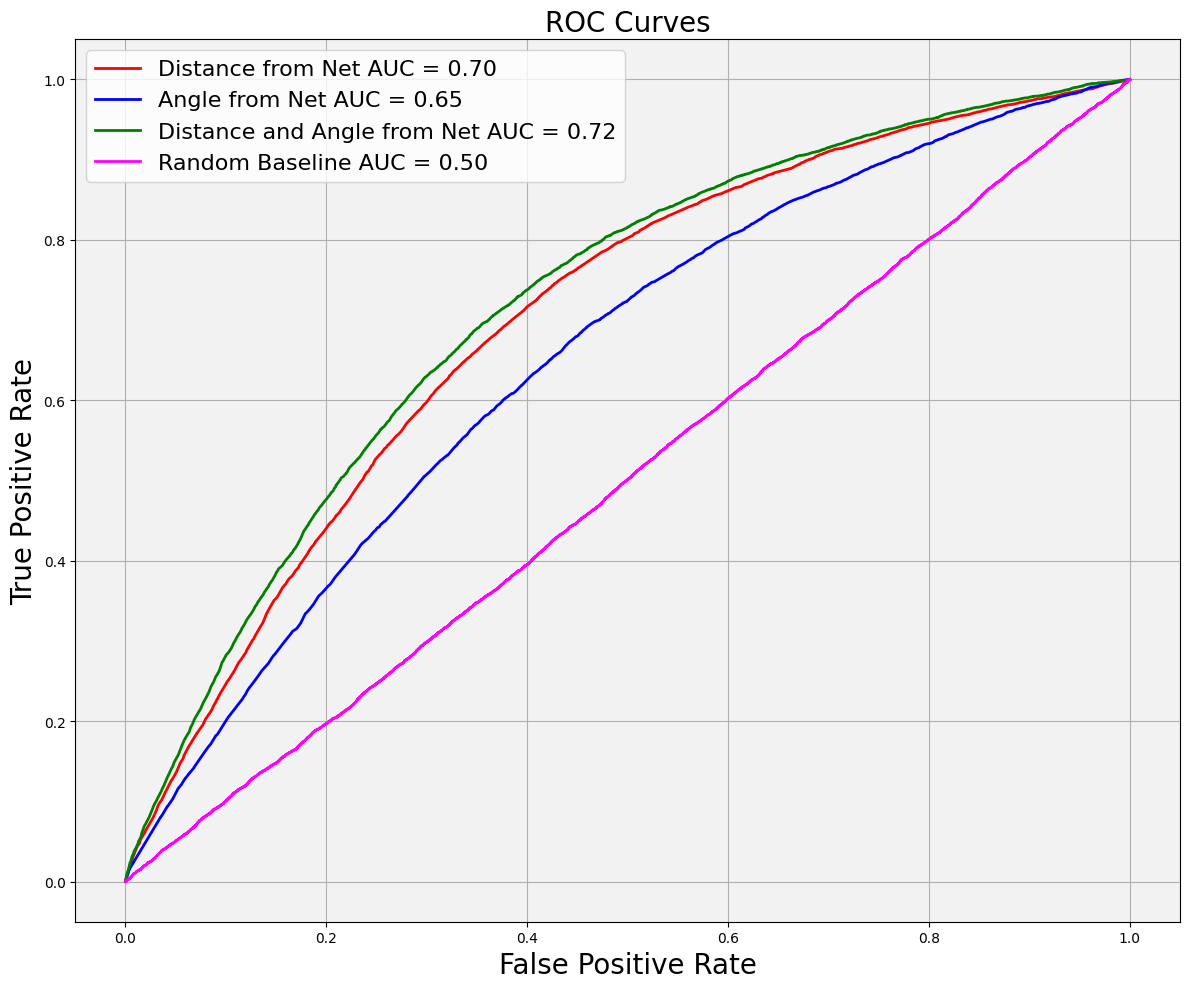

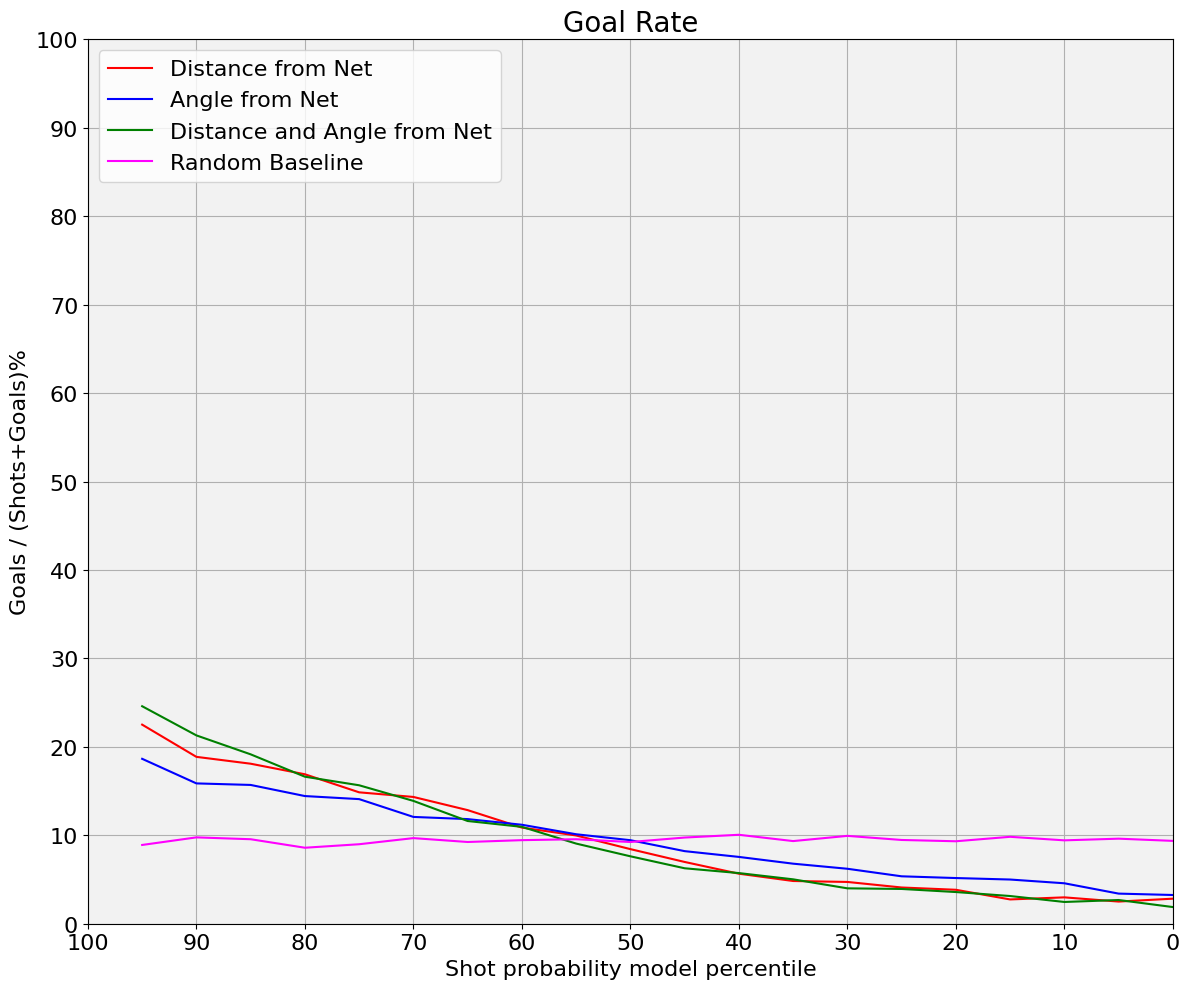

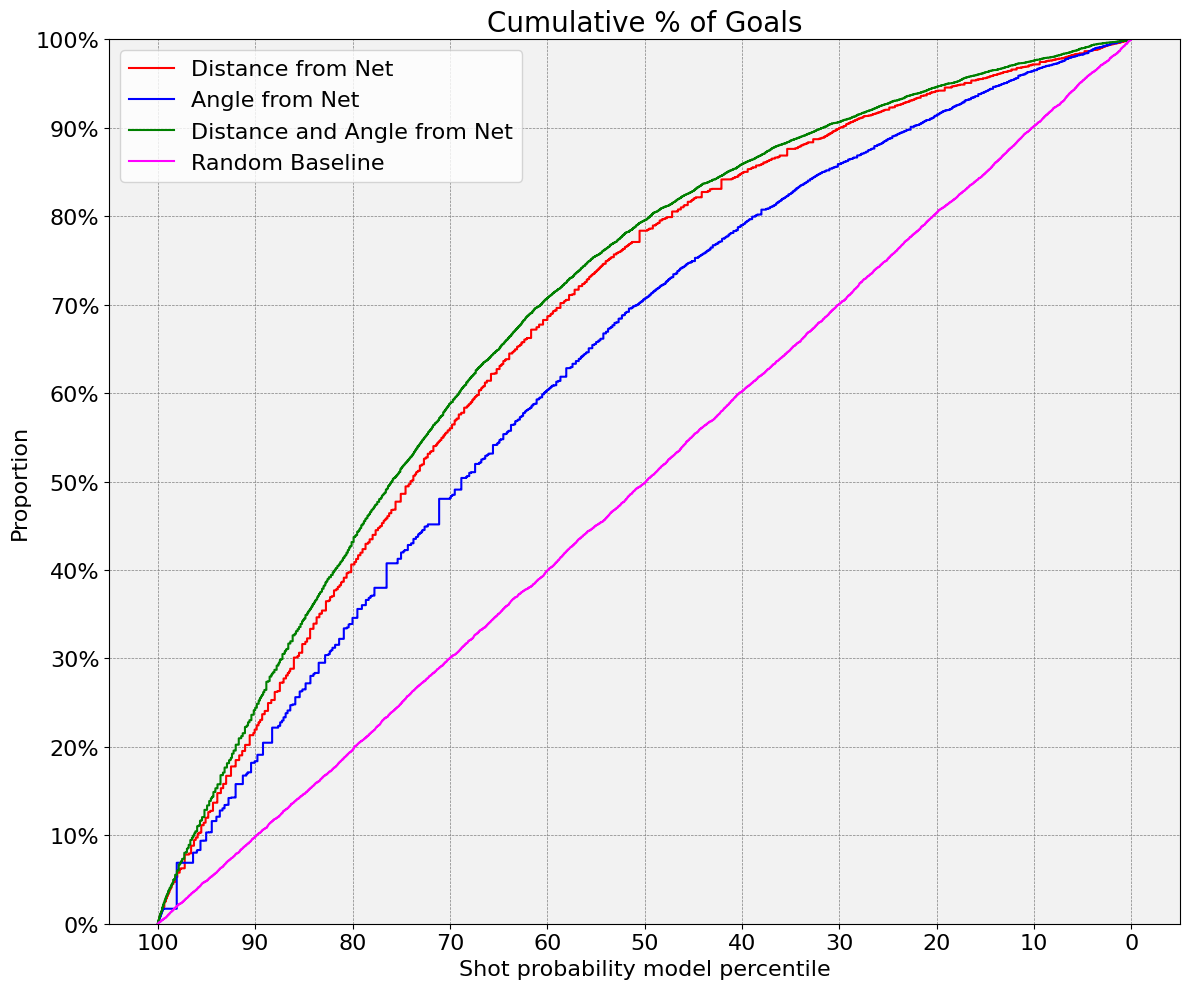

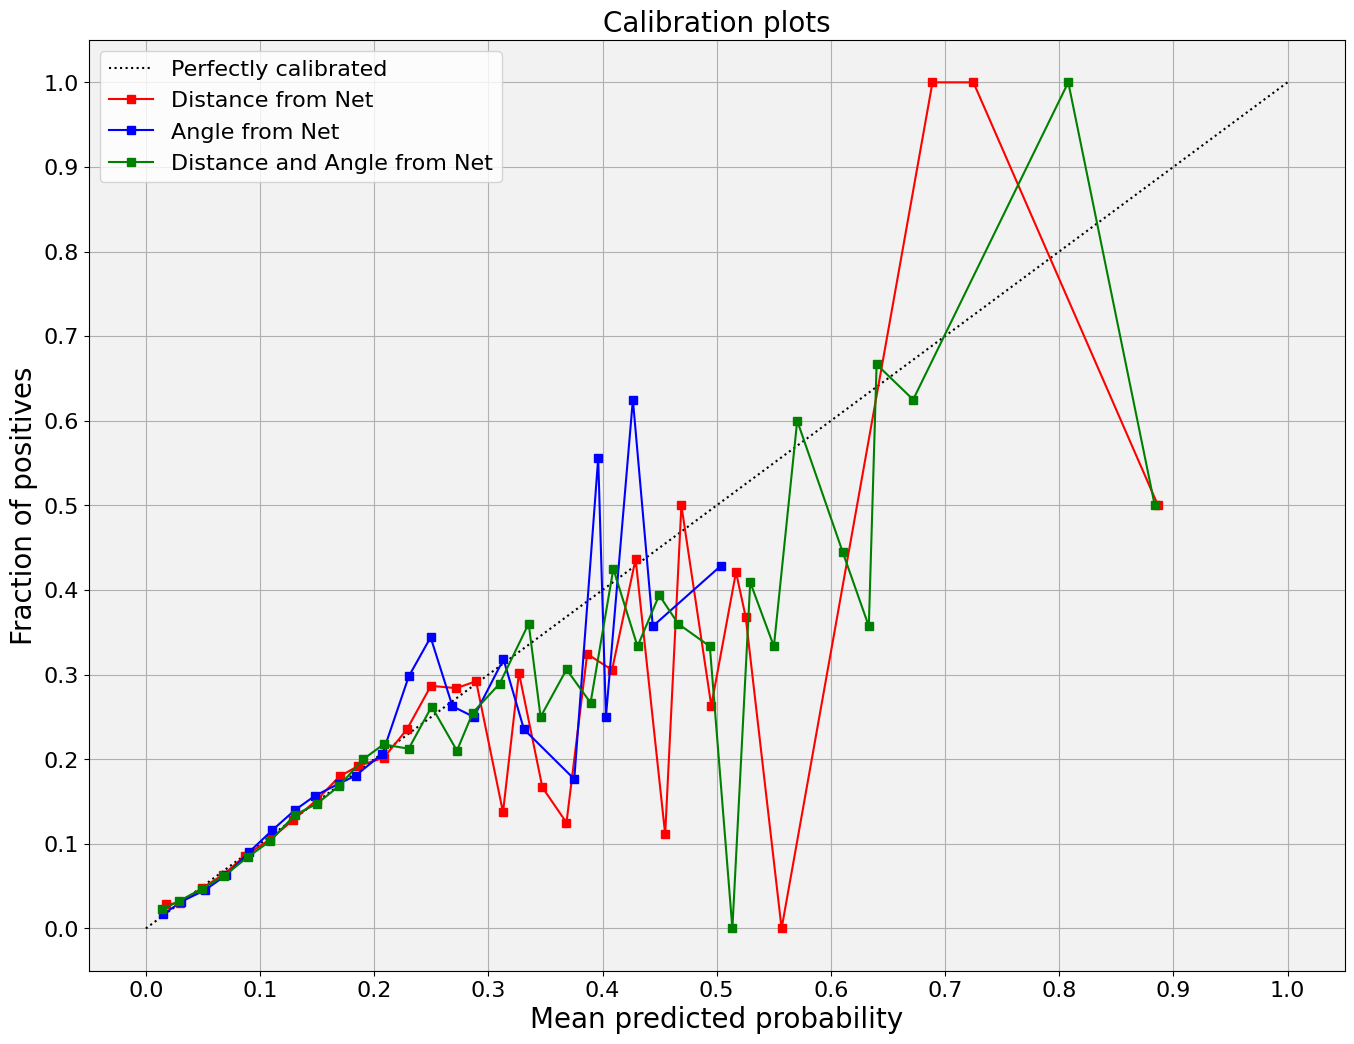

In [9]:
feature_list = (['shotDistance'], ['shotAngle'], ['shotDistance', 'shotAngle'])
model_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']
color_list = ['red', 'blue', 'green']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

y_preds = []

for i, feature in enumerate(feature_list):
    
    # Fit the model
    model.fit(X_train[feature], y_train)
    
    # Obtain the predictions and prediction probabilities
    y_pred_prob = model.predict_proba(X_val[feature])
    
    y_val_is_goal = y_val
    y_preds.append(y_pred_prob[:,1])

plot_roc_all_feat(y_val, y_preds, model_list, '5-1a ROC Curves', color_list)
plot_goal_rate_all_feat(y_val, y_preds, model_list, '5-1b Goal rate', color_list)
plot_cumulative_rate_all_feat(y_val, y_preds, model_list, '5-1c Cumulative Goal Percentage', color_list)
plot_calibration_all_feat(y_val, y_preds, model_list, '5-1d Calibration Plots', color_list)